In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai import *

##### This notebook will show how a classifier (resnet18) is able to predict between two classes when it is trained with one of the channels being randomly ignored (set to zero) for each sample.
This is being tested for the reasons mentioned in the notebook `Simple_donkeys_vs_horses.ipynb` :
> ##### We build a simple Donkey VS Horses classifier here with a pretrained resnet18 network to see how it compares to the same classifier when a channel is ignored at random during training. The objective is to test a hypothesis that a similar technique will work for the Human Protein Atlas (HPA) dataset on Kaggle
> The motivation for trying this out is the fact that the HPA Dataset on Kaggle has samples with 4 channels each. On talking to some Cell Biology professors in my university, I realized that most biologists have equipment to get imagery of only 3 channels. Hence, a model trained on this dataset might prove unuseful to the people who actually need it. <br>
By training a model with a random channel ignored for each sample, I predict that the model may learn to work with less information and and still get good, if not the best accuracy which would still be infinitely better than an unusable model

In [95]:
PATH = Path('data')

In [96]:
def remove_random_channels(tensor):
        """
        Assumes tensor.shape = [batch_size, channels, height_or_width, height_or_width]
        For each training sample in a batch:
        1. Selects a random number `N` in range (0, number_of_channels)
        2. Sets all values in channel N to zero
        """
        if isinstance(tensor, Image):
            tensor = tensor.data
        num_channels = tensor.shape[0]

        #randomly select a different channel to be ignored for each sample in a batch
        random_channel = np.random.randint(0, num_channels)

        #replce selected channels of samples with zeros

        tensor[random_channel] = torch.zeros_like(tensor[random_channel])
        return tensor

def get_custom_transforms():
    tfms = get_transforms()
    add_to_tfms = TfmPixel(remove_random_channels)
    add_to_tfms = RandTransform(add_tfms, kwargs={}, p=1.0)
    tfms[0].append(add_to_tfms)
    tfms[1].append(add_to_tfms)
    return tfms

In [97]:
data = ImageDataBunch.from_folder(PATH, ds_tfms=get_custom_transforms(), size=224, valid_pct=0.2, bs=8)

The callback below will help us in implementing the necessary steps needed to ignore a channel randomly for each training sample

In [98]:
## This callback will be ignored for now as the necessary functionality has been implemented in
## the transforms used for data augmentation

@dataclass
class ignore_random_channel(Callback):
    learn:Learner
    
    def on_batch_begin(self, *args, **kwargs):
        """
        Recieves `xb` as an argument.
        `xb` is the current batch of images that is being fed into the model.
        """
        # Removes a channel from each sample in the batch
        self.remove_channel_random(xb)
        
    def remove_channel_random(self, tensor):
        """
        Assumes tensor.shape = [batch_size, channels, height_or_width, height_or_width]
        For each training sample in a batch:
        1. Selects a random number `N` in range (0, number_of_channels)
        2. Sets all values in channel N to zero
        """
        batch_size, num_channels = tensor.shape[:2]

        #randomly select a different channel to be ignored for each sample in a batch
        random_channels = np.random.randint(0, num_channels, size=batch_size)

        #replce selected channels of samples with zeros
        for i in range(batch_size):
            tensor[i, random_channels[i]] = torch.zeros_like(tensor[i, random_channels[i]])

In [104]:
learn = create_cnn(data, models.resnet18)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


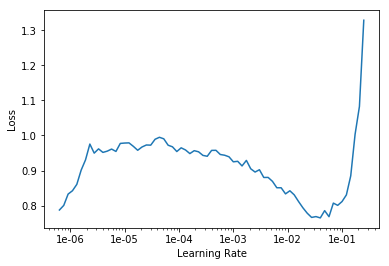

In [105]:
learn.lr_find()
learn.recorder.plot()

In [106]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss
1,0.681296,0.781200
2,0.621557,0.489264
3,0.537024,0.304691


In [107]:
learn.metrics.append(accuracy)
learn.validate(learn.data.valid_dl)

[0.30469128, tensor(0.9059)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


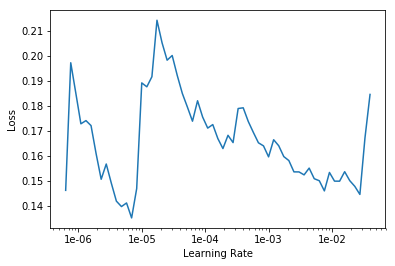

In [29]:
learn.lr_find()
learn.recorder.plot()

In [108]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,0.364408,0.254623,0.894118
2,0.383977,0.246336,0.894118
3,0.303859,0.231698,0.905882


In [109]:
learn.freeze_to(-3)

In [110]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,0.554444,1.276677,0.729412
2,0.643763,1.804649,0.564706
3,0.578691,0.617362,0.811765
4,0.556096,0.347950,0.858824
5,0.489251,0.385998,0.835294


In [115]:
learn.fit_one_cycle(5, 5e-4)

epoch,train_loss,valid_loss,accuracy
1,0.458775,0.450345,0.800000
2,0.481872,0.743446,0.647059
3,0.387585,0.292987,0.847059
4,0.362189,0.436861,0.788235
5,0.316507,0.301816,0.894118


In [116]:
learn.save('frozen_ignnored_resnet18_9_epochs')

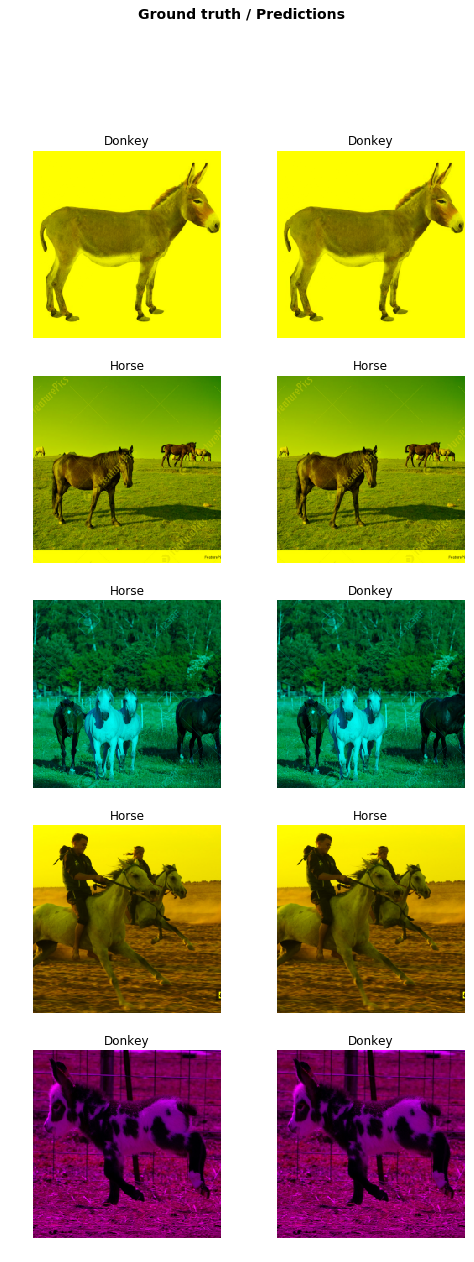

In [112]:
learn.show_results()

In [117]:
interpret = ClassificationInterpretation.from_learner(learn)

As we can see, about half of the images that the model is incorrect on are not representative of actual donkeys or horses :

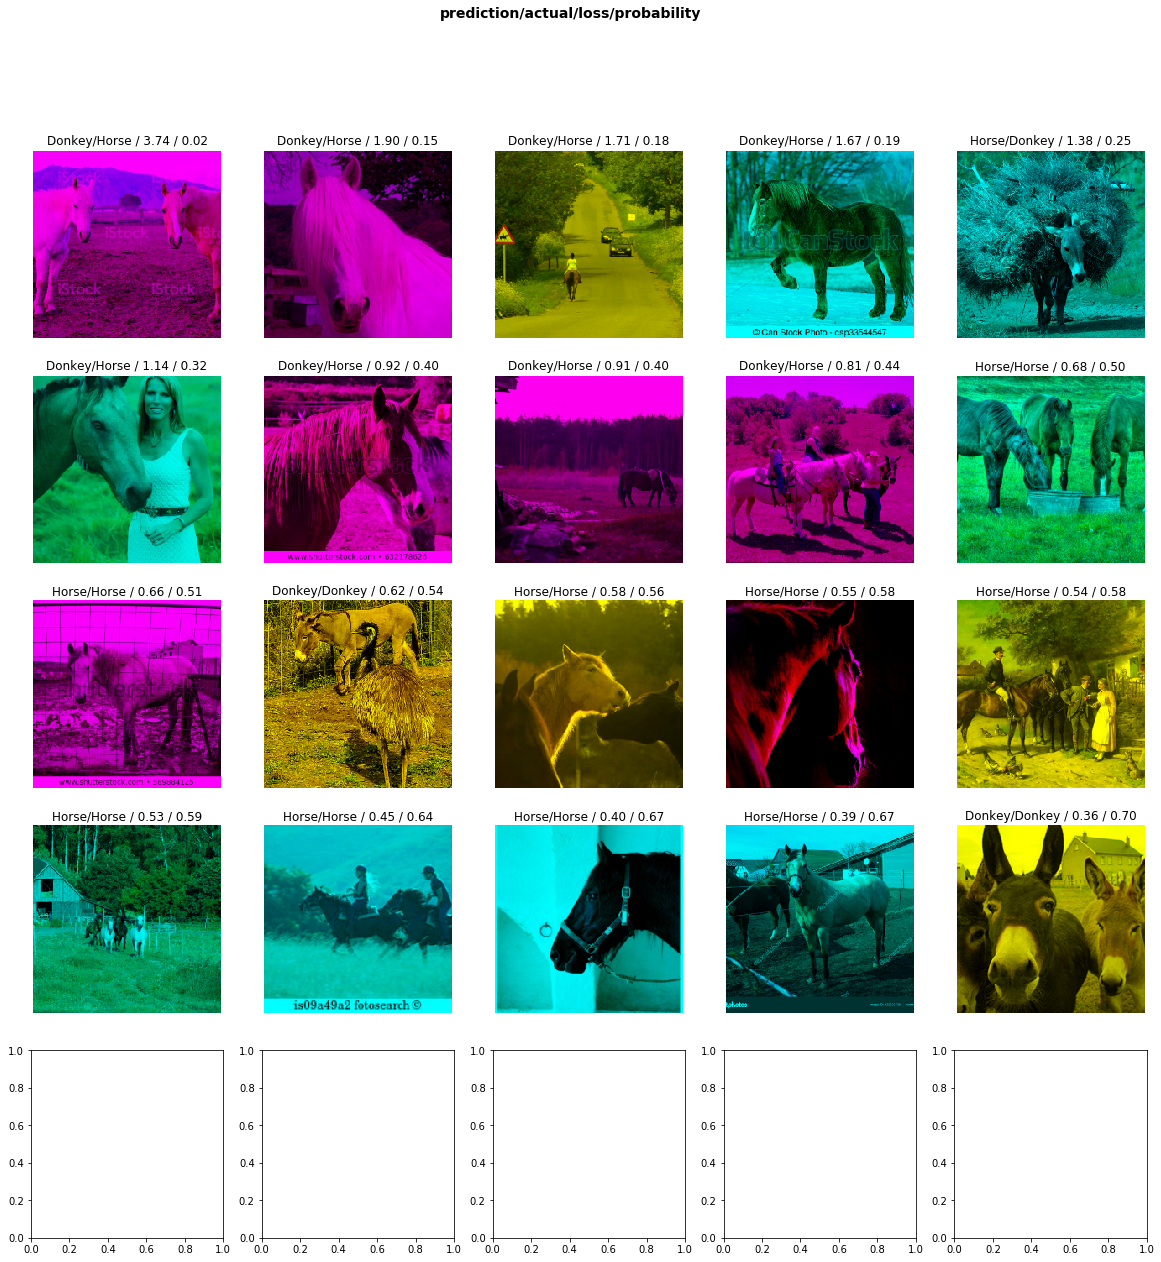

In [118]:
interpret.plot_top_losses(20, figsize=(20,20))

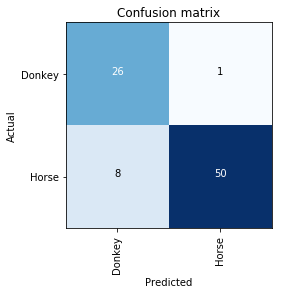

In [119]:
interpret.plot_confusion_matrix()

<br>
The method without ignoring channels (`Simple_donkeys_vs_horses.ipynb`) was 96.6% accurate. We can safely say that with a little more training, a result close to the previous one will also be achievable in the current setting.<br>

**Hence it is safe to conclude that a model can perform almost as well even if a channel is ignored for each image in the training data.**

<hr>

In [7]:
learn.load('frozen_ignnored_resnet18_9_epochs')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (343 items)
[Category Donkey, Category Donkey, Category Donkey, Category Donkey, Category Donkey]...
Path: data
x: ImageItemList (343 items)
[Image (3, 1600, 2400), Image (3, 3000, 4000), Image (3, 800, 800), Image (3, 1736, 2048), Image (3, 720, 1280)]...
Path: data;
Valid: LabelList
y: CategoryList (85 items)
[Category Donkey, Category Horse, Category Horse, Category Donkey, Category Donkey]...
Path: data
x: ImageItemList (85 items)
[Image (3, 478, 745), Image (3, 549, 976), Image (3, 667, 1000), Image (3, 400, 300), Image (3, 420, 700)]...
Path: data;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
  